# Importing Important Libraries

In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import L2
import warnings

# Taking Json File From Kaggle API To Use IT Insted Of Downloding The Files


In [2]:
from google.colab import files
files.upload()      # upload kaggle.json
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


# Unziping Files

In [3]:
! unzip /content/dogs-vs-cats.zip

Archive:  /content/dogs-vs-cats.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


# Unziping Train

In [4]:
! unzip /content/train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

#Visualzie To See Samples From The Data

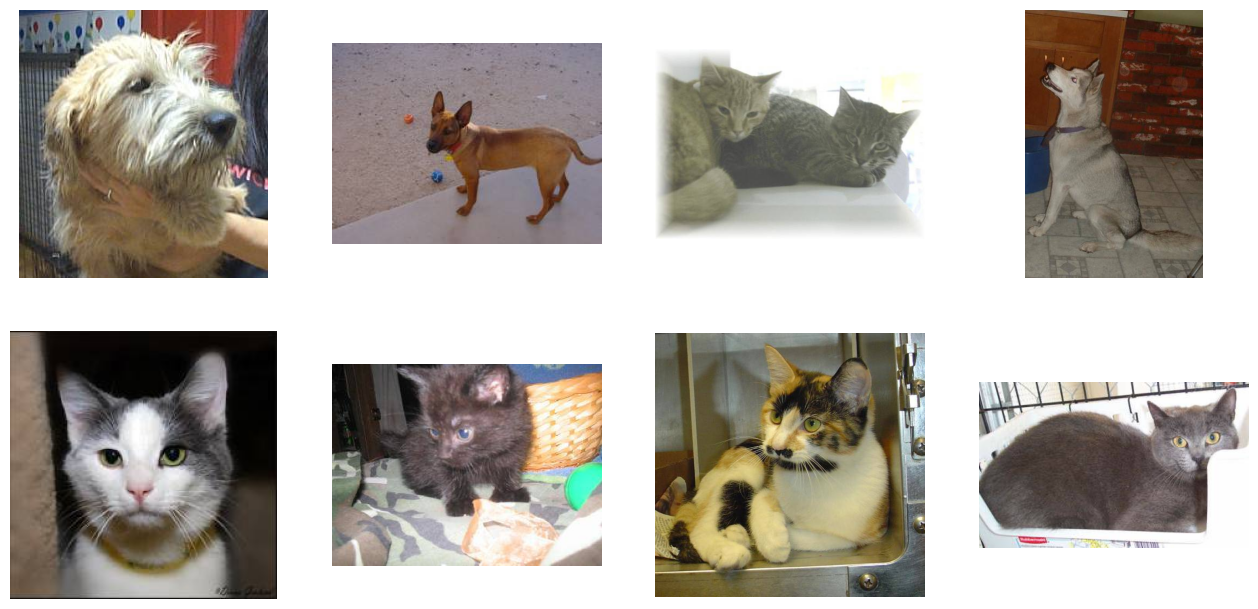

In [5]:
plt.figure(figsize=(16,16))

images = os.listdir('/content/train')
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join('/content/train', img))
    fig.imshow(img)

# Making Folders

In [6]:
try:
    parent_dir = 'cats-v-dogs'
    os.mkdir(parent_dir)

    for dir in ['training', 'validation']:
        path = os.path.join(parent_dir , dir)
        os.mkdir(path)
        for dir in ['cats', 'dogs']:
            n_path = os.path.join(path , dir)
            os.mkdir(n_path)
except OSError:
    print('Existed')

Existed


# Getting The Labels From The Images And Moving The Photos From The Zip File To The Folders We Made

In [7]:
src_dir = '/content/train'

# List of cats names in all training images
cats =[img for img in os.listdir(src_dir) if img[:3]=='cat']
# List of Dogs names in all training images
dogs =[img for img in os.listdir(src_dir) if img[:3]== 'dog']

# Intialize dirs
cats_train_dir = '/content/cats-v-dogs/training/cats'
cats_valid_dir = '/content/cats-v-dogs/validation/cats/'
dogs_train_dir = '/content/cats-v-dogs/training/dogs/'
dogs_valid_dir = '/content/cats-v-dogs/validation/dogs/'

cats_valid_sample = random.sample(cats, int(0.1*len(cats)))
dogs_valid_sample = random.sample(dogs, int(0.1*len(dogs)))

# Moving The Photos From The Original Dir To The Destenation Dir

In [8]:
if len(os.listdir(src_dir)) > 0:
    for img in os.listdir(src_dir):
        src_img = os.path.join(src_dir, img)

        if img[:3] == 'cat':
            if img in cats_valid_sample:
                dest_img = os.path.join(cats_valid_dir, img)
            else:
                dest_img = os.path.join(cats_train_dir, img)

        elif img[:3] == 'dog':
            if img in dogs_valid_sample:
                dest_img = os.path.join(dogs_valid_dir, img)
            else:
                dest_img = os.path.join(dogs_train_dir, img)

        shutil.move(src_img, dest_img)
else:
    print('All images moved')

# Some Statstics About The Classes And It's Numbers

In [9]:
print('No. of ALL cats : ', len(cats))
print('No. of cats for training: ', len(os.listdir(cats_train_dir)))
print('No. of cats for validation: ', len(os.listdir(cats_valid_dir)))

print('\nNo. of ALL dogs : ', len(dogs))
print('No. of dogs for training: ', len(os.listdir(dogs_train_dir)))
print('No. of dogs for validation: ', len(os.listdir(dogs_valid_dir)))

No. of ALL cats :  12500
No. of cats for training:  12374
No. of cats for validation:  2374

No. of ALL dogs :  12500
No. of dogs for training:  12372
No. of dogs for validation:  2372


# Image Data Genrator And Normalization

In [10]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
# Normalization

train_dir = '/content/cats-v-dogs/training'
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

valid_dir = '/content/cats-v-dogs/validation'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150, 150), batch_size=32,class_mode='binary')

Found 24746 images belonging to 2 classes.
Found 4746 images belonging to 2 classes.


In [11]:
print(valid_generator.class_indices)

{'cats': 0, 'dogs': 1}


# Expermint On A Small Model

In [12]:
model = Sequential([    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                        MaxPooling2D(2, 2),
                        Conv2D(64, (3,3), activation='relu'),
                        MaxPooling2D(2,2),
                        Conv2D(128, (3,3), activation='relu'),
                        MaxPooling2D(2,2),

                        Flatten(),
                        Dense(128, activation='relu'),
                        Dense(1, activation='sigmoid')  ])

# Compile model
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(train_generator, epochs=5, verbose=1,validation_data=valid_generator)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


774/774 ━━━━━━━━━━━━━━━━━━━━ 67s 79ms/step - accuracy: 0.6046 - loss: 0.6574 - val_accuracy: 0.7581 - val_loss: 0.4980
Epoch 2/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 50s 65ms/step - accuracy: 0.7602 - loss: 0.4974 - val_accuracy: 0.7994 - val_loss: 0.4328
Epoch 3/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.8061 - loss: 0.4226 - val_accuracy: 0.8316 - val_loss: 0.3722
Epoch 4/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 50s 65ms/step - accuracy: 0.8356 - loss: 0.3694 - val_accuracy: 0.8727 - val_loss: 0.3078
Epoch 5/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 52s 68ms/step - accuracy: 0.8682 - loss: 0.3100 - val_accuracy: 0.8997 - val_loss: 0.2638


<Axes: >

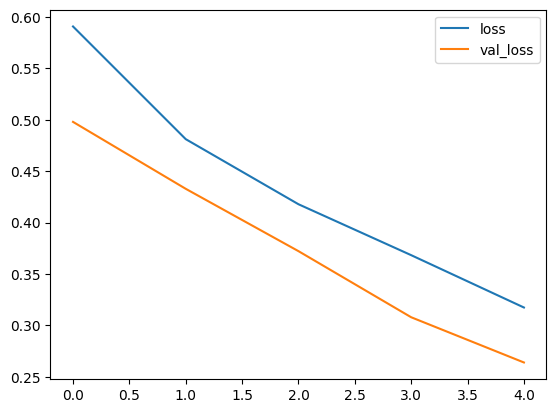

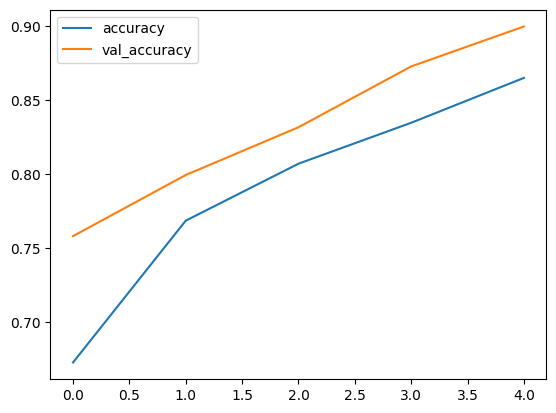

In [14]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

# In The Last Epoch I Saw There Is A Big Differnce Between Validate And Accuracy So It Seems Overfit So i Will Go To Data Augmantaion

In [15]:
aug_train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=90,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1/255)

train_dir = '/content/cats-v-dogs/training'
aug_train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

valid_dir = '/content/cats-v-dogs/validation'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150, 150), batch_size=32,class_mode='binary')

Found 24746 images belonging to 2 classes.
Found 4746 images belonging to 2 classes.


In [16]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('/content/cats-v-dogs/weights.best.keras', monitor='val_loss', save_best_only=True)]

# create model
aug_model = Sequential([    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                            MaxPooling2D(2, 2),
                            Conv2D(64, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Conv2D(128, (3,3), activation='relu'),
                            MaxPooling2D(2,2),

                            Flatten(),
                            Dense(128, activation='relu'),
                            Dense(1, activation='sigmoid')  ])

# load weights if exists
if os.path.exists("/content/cats-v-dogs/weights.best.keras"):
    aug_model.load_weights("/content/cats-v-dogs/weights.best.keras")

# Compile model
aug_model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
aug_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
aug_history = aug_model.fit(aug_train_generator, epochs=5, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


774/774 ━━━━━━━━━━━━━━━━━━━━ 56s 68ms/step - accuracy: 0.8440 - loss: 0.3548 - val_accuracy: 0.8019 - val_loss: 0.4329
Epoch 2/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - accuracy: 0.8645 - loss: 0.3138 - val_accuracy: 0.8799 - val_loss: 0.2912
Epoch 3/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 50s 65ms/step - accuracy: 0.8833 - loss: 0.2788 - val_accuracy: 0.8987 - val_loss: 0.2484
Epoch 4/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.9044 - loss: 0.2356 - val_accuracy: 0.9172 - val_loss: 0.2127
Epoch 5/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.9227 - loss: 0.1943 - val_accuracy: 0.9326 - val_loss: 0.1769


# Trying In Hyper Parameter Tuning

In [18]:
!pip install keras-tuner

Now, we'll define a function that builds the model with hyperparameters to tune.

In [19]:
import keras_tuner as kt
from tensorflow.keras.layers import Input, Dropout

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(150, 150, 3)))
    model.add(Conv2D(hp.Int('conv_1_filter', min_value=32, max_value=128, step=16), (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(hp.Int('conv_2_filter', min_value=32, max_value=64, step=16), (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(hp.Int('conv_3_filter', min_value=64, max_value=128, step=16), (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))

    model.add(Flatten())
    model.add(Dense(hp.Int('dense_1_units', min_value=64, max_value=256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'adamax']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

Next, we'll set up the Keras Tuner. We'll use the RandomSearch tuner, but other tuners like Hyperband are also available.

In [20]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of different models to try
    executions_per_trial=1, # Number of models to train for each trial
    directory='my_dir',
    project_name='cats_vs_dogs_tuning')

Reloading Tuner from my_dir/cats_vs_dogs_tuning/tuner0.json


Now, we'll run the hyperparameter search. This will train multiple models with different hyperparameters.

In [21]:
tuner.search(aug_train_generator, epochs=5, validation_data=valid_generator)

After the search is complete, you can get the best model and its hyperparameters.

In [22]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

print("Best Model Summary:")
best_model.summary()

print("\nBest Hyperparameters:")
print(best_hyperparameters.values)

Best Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │     3,551,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,580,257 (13.66 MB)

 Trainable params: 3,580,257 (13.66 MB)

 Non-trainable params: 0 (0.00 B)


Best Hyperparameters:
{'conv_1_filter': 32, 'conv_2_filter': 32, 'conv_3_filter': 64, 'dense_1_units': 192, 'optimizer': 'rmsprop', 'dropout': 0.0}


# Let's Try The Parameters After Tuning

In [23]:
aug_history_Tuned = best_model.fit(aug_train_generator, epochs=10, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9073 - loss: 0.2375 - val_accuracy: 0.9292 - val_loss: 0.1894
Epoch 2/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 50s 65ms/step - accuracy: 0.9461 - loss: 0.1459 - val_accuracy: 0.9313 - val_loss: 0.1912
Epoch 3/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - accuracy: 0.9678 - loss: 0.0863 - val_accuracy: 0.9777 - val_loss: 0.0730
Epoch 4/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 49s 64ms/step - accuracy: 0.9842 - loss: 0.0461 - val_accuracy: 0.9817 - val_loss: 0.0668
Epoch 5/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - accuracy: 0.9893 - loss: 0.0351 - val_accuracy: 0.9819 - val_loss: 0.0649
Epoch 6/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.9897 - loss: 0.0314 - val_accuracy: 0.9863 - val_loss: 0.0638
Epoch 7/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - accuracy: 0.9942 - loss: 0.0179 - val_accuracy: 0.9878 - val_loss: 0.0623
Epoch 8/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 49s 64ms/step - accuracy: 0.9936 - loss: 0.0230 - 

# Let's Try Transfer Learning With A VGG-16 Pre Trained Model

In [24]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/cats-v-dogs/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-10-16 17:36:07--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.207, 172.217.218.207, 142.251.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/cats-v-dogs/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/cats-v-dog 100%[===================>]  83.84M  31.8MB/s    in 2.6s    

2025-10-16 17:36:10 (31.8 MB/s) - ‘/content/cats-v-dogs/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [25]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/content/cats-v-dogs/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [26]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 74, 74,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d_3[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [27]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output)
last_output = last_layer.output

last layer output shape:  <KerasTensor shape=(None, 7, 7, 768), dtype=float32, sparse=False, ragged=False, name=keras_tensor_284>


In [28]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 74, 74,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d_3[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [29]:
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [30]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('/content/cats-v-dogs/weights_tf.best.keras', monitor='val_loss', save_best_only=True)]

# Train the model.
history = model.fit(aug_train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/20
774/774 ━━━━━━━━━━━━━━━━━━━━ 80s 88ms/step - accuracy: 0.9359 - loss: 0.1722 - val_accuracy: 0.9882 - val_loss: 0.0350
Epoch 2/20
774/774 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.9844 - loss: 0.0437 - val_accuracy: 0.9956 - val_loss: 0.0191
Epoch 3/20
774/774 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - accuracy: 0.9935 - loss: 0.0202 - val_accuracy: 0.9981 - val_loss: 0.0105
Epoch 4/20
774/774 ━━━━━━━━━━━━━━━━━━━━ 56s 73ms/step - accuracy: 0.9982 - loss: 0.0068 - val_accuracy: 0.9985 - val_loss: 0.0067
Epoch 5/20
774/774 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.9997 - loss: 0.0020 - val_accuracy: 0.9989 - val_loss: 0.0066
Epoch 6/20
774/774 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.9999 - loss: 8.9164e-04 - val_accuracy: 0.9989 - val_loss: 0.0061
Epoch 7/20
774/774 ━━━━━━━━━━━━━━━━━━━━ 53s 69ms/step - accuracy: 0.9999 - loss: 7.3202e-04 - val_accuracy: 0.9989 - val_loss: 0.0062
Epoch 8/20
774/774 ━━━━━━━━━━━━━━━━━━━━ 56s 72ms/step - accuracy: 0.9999 - loss: 5

774/774 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.9999 - loss: 2.0082e-04
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9996 - loss: 0.0022
Transfer Learning Model Accuracy on Training Data:  0.9999191761016846
Transfer Learning Model Accuracy on Validation Data:  0.999157190322876


<Axes: >

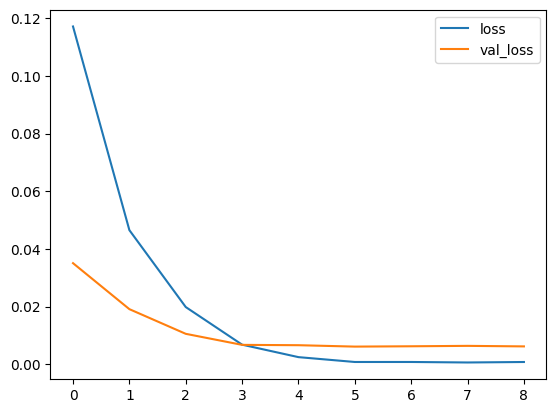

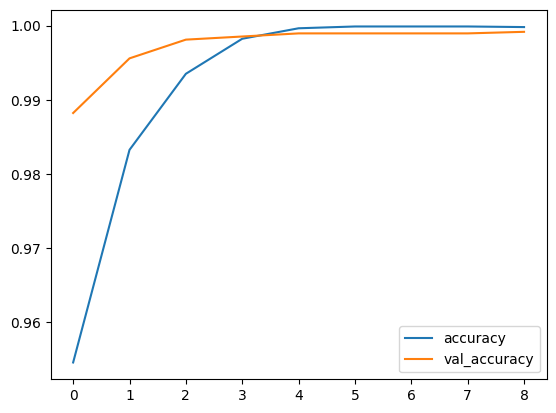

In [31]:
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(valid_generator)[1]
print("Transfer Learning Model Accuracy on Training Data: ", train_acc)
print("Transfer Learning Model Accuracy on Validation Data: ", valid_acc)
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

#Saving Model

In [32]:
model.save('/content/cats-v-dogs/inception_model.keras')

#Unziping Test

In [33]:
! unzip /content/test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

#preparing The Test Images

In [34]:
from tensorflow.keras.preprocessing import image

def convert_one_img(img_folder, img):
  # dimensions of image
    img_width, img_height = 150, 150
    img = os.path.join(img_folder, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255

    return img

In [35]:
from tensorflow.keras.models import load_model
model = load_model('/content/cats-v-dogs/inception_model.keras')

def predict_visualize_img(img_folder, img, model):
    img_fig = mpimg.imread(os.path.join(img_folder, img))
    plt.imshow(img_fig)

    img_prepared = convert_one_img(img_folder, img)
    pred = model.predict(img_prepared)[0][0]
    if pred <= 0.5:
        result = 'Predicted : Cat'
    else:
        result = 'Predicted : Dog'

    plt.title(result)
    return pred

In [36]:
test_dir = '/content/test1'

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


np.float32(0.004044303)

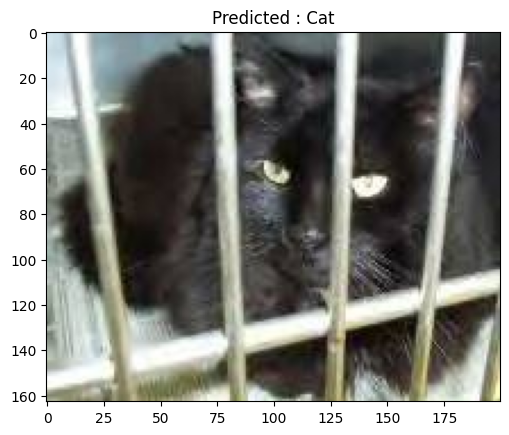

In [37]:
x = random.choice()
predict_visualize_img(test_dir, os.listdir(test_dir)[5], model)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Now, let's get the predictions from your model on the prepared test images and then generate the classification report and confusion matrix. Since your test data doesn't have ground truth labels, we can't generate a standard classification report or confusion matrix. However, we can visualize the predictions and their corresponding images. If you had a labeled test set, you would replace `test_images_prepared` and provide the true labels to calculate the metrics.

In [ ]:
# Assuming you have true labels for your test data in a variable called 'test_labels'
# If you don't have test_labels, you can skip the classification report and confusion matrix.

# Get the true labels for the test set (replace with your actual test labels)
# For demonstration, we'll assume a dummy array of test labels.
# In a real scenario, you would load or create your test labels.
# For this dataset, the test set is unlabeled, so we cannot calculate these metrics.
# If you had a labeled test set, you would replace the line below with your actual test labels.
# For example:
# test_labels = np.array([0, 1, 0, 1, ...]) # Replace with your actual test labels

# If you have test labels, uncomment the following lines to generate the report and matrix:

print("Classification Report:")
print(classification_report(test_labels, pred_test_images))

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, pred_test_images))

# Since this test set is unlabeled, we will just display some predictions with their images.
print("Sample predictions:")
for i in range(5):
    x = random.choice(os.listdir(test_dir))
    predict_visualize_img(test_dir, x, model)
    plt.show()

In [38]:
def convert_imgs_to_tensors(img_folder):

  # load all images into a list
  images = []

  for img in os.listdir(img_folder):
    img = convert_one_img(img_folder, img)
    images.append(img)

  # stack up images list to pass for model
  images = np.vstack(images)

  return images

In [39]:
test_images_prepared = convert_imgs_to_tensors(test_dir)

In [ ]:
pred_test_images = (model.predict(test_images_prepared) > 0.5).astype('int')


In [ ]:
test_data = os.listdir(test_dir)
test_df = pd.DataFrame({ "id" : test_data})
test_df['id'] = test_df['id'].str.split('.').str[0]
test_df['label'] = pred_test_images
test_df.head()


In [ ]:
test_df.to_csv('/content/cats-v-dogs/my_first_preds.csv')